## Importación de librerías

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
import joblib

## Configuración de variables globales

In [2]:
with open('setup.json', 'r') as f:
    SETUP_JSON = json.load(f)
FINAL_DATASET = SETUP_JSON['final_dataset']
LEARNING_RATE = SETUP_JSON['learning_rate']
EPOCHS = SETUP_JSON['epochs']

## Cargar el dataset

In [3]:
df = pd.read_parquet(FINAL_DATASET) # Leer dataset final
df.shape

(8247888, 34)

In [4]:
df.head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code,Sequence ID
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0,1
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0,1


## Análisis de las clases

In [5]:
# Mapeo de etiquetas
labels = df['Label'].unique()
labels_codes = df['Label Code'].unique()
label_mapping = {int(label_code): label for label_code, label in zip(labels_codes, labels)}
label_mapping

{0: 'Benign',
 1: 'FTP-BruteForce',
 2: 'SSH-Bruteforce',
 3: 'DoS attacks-GoldenEye',
 4: 'DoS attacks-Slowloris',
 5: 'DoS attacks-SlowHTTPTest',
 6: 'DoS attacks-Hulk',
 7: 'DDOS attack-LOIC-UDP',
 8: 'DDOS attack-HOIC',
 9: 'Brute Force -Web',
 10: 'Brute Force -XSS',
 11: 'SQL Injection',
 12: 'Infilteration',
 13: 'Bot'}

## Extracción de secuencias de paquetes

In [7]:
sequences = []

# Obtener una lista de DataFrames de secuencias
sequences = [seq[1].drop(columns=['Sequence ID']) for seq in df.groupby('Sequence ID')]
print(f"Total de secuencias: {len(sequences)}")

Total de secuencias: 939866


In [9]:
sequences[0].head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.00,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.00,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.00,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,140.48,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,134.08,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0


In [10]:
sequences[-1].tail()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code
8247883,0.5,3389,6,14.0,1442.0,725.0,103.000000,1179.0,0.0,216.375,...,144.227273,103.000000,216.375,14.0,1442.0,8192.0,7.0,20.0,Benign,0
8247884,0.5,3389,6,14.0,1440.0,725.0,102.857143,1179.0,0.0,216.375,...,144.136364,102.857143,216.375,14.0,1440.0,8192.0,7.0,20.0,Benign,0
8247885,0.5,3389,6,14.0,1459.0,741.0,104.214286,1179.0,0.0,216.375,...,145.000000,104.214286,216.375,14.0,1459.0,8192.0,7.0,20.0,Benign,0
8247886,0.5,3389,6,14.0,1459.0,741.0,104.214286,1179.0,0.0,216.375,...,145.000000,104.214286,216.375,14.0,1459.0,8192.0,7.0,20.0,Benign,0
8247887,0.5,3389,6,14.0,1439.0,725.0,102.785714,1179.0,0.0,216.375,...,144.090909,102.785714,216.375,14.0,1439.0,8192.0,7.0,20.0,Benign,0


## Análisis de las secuencias

Análisis estadístico de las secuencias

In [11]:
sequences_df = pd.DataFrame({
    'Longitud': [len(seq) for seq in sequences],
    'Clase': [seq['Label'].iloc[0] for seq in sequences]
})

In [12]:
sequences_df.head()

,Longitud,Clase
0,94,Benign
1,64,FTP-BruteForce
2,1,Benign
3,5610,FTP-BruteForce
4,1,Benign


Ver número de secuencias por clase

In [13]:
sequences_df['Clase'].value_counts()

Clase
Benign                      458797
DoS attacks-Hulk            246538
DDOS attack-HOIC            172030
Infilteration                29269
SSH-Bruteforce                8342
FTP-BruteForce                7557
Bot                           6737
DoS attacks-GoldenEye         5026
DoS attacks-Slowloris         4668
DDOS attack-LOIC-UDP           635
Brute Force -XSS               109
Brute Force -Web                73
DoS attacks-SlowHTTPTest        53
SQL Injection                   32
Name: count, dtype: int64

## Preparación de las secuencias

Seleccionar las secuencias con más de 1 paquete

In [ ]:
sequences = [seq for seq in sequences if len(seq) > 1]
len(sequences)

15505

Asegurar que el dataset esté balanceado (establecer un número adecuado de secuencias por clase) 

In [17]:
sequence_label_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences]
})

# Obtener número medio de secuencias por clase
mean_num_sequences_by_label = sequence_label_df['Clase'].value_counts().mean()
int(mean_num_sequences_by_label)

1192

In [ ]:
# Fijar la media como número de las secuencias para las clases con más secuencias que la media


In [ ]:
sequence_label_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences]
})

sequence_label_df['Clase'].value_counts()

## Separación de datos

In [18]:
# Definir el tamaño de la secuencia
sequence_size = int(np.median(pd.DataFrame({'Longitud': [len(seq) for seq in sequences],})['Longitud']))
sequence_size

24

In [19]:
X = []
y = []

for seq in sequences:
    sequence_X = seq.drop(columns=['Label', 'Label Code']) # Obtener las características
    sequence_Y = seq['Label Code'].iloc[0] # Obtener la etiqueta

    if len(sequence_X) < sequence_size:
        # Rellenar con ceros
        pad_width = sequence_size - len(sequence_X)
        sequence_X = np.pad(sequence_X, ((0, pad_width), (0, 0)), mode='constant')
    else:
        # Recortar
        sequence_X = sequence_X.iloc[:sequence_size]
        
    X.append(sequence_X)
    y.append(sequence_Y)

X = np.array(X)
y = np.array(y)

In [20]:
X.shape, y.shape

((15505, 24, 31), (15505,))

Escalamiento de características

In [21]:
num_features = sequences[0].shape[1] - 2  # Restar 2 por 'Label' y 'Label Code'
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, num_features)).reshape(len(y), sequence_size, num_features)

## Separar secuencias en entrenamiento, validación y prueba

Separación de datos

In [18]:
# Separar en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
def concatenate_sequences(sequences):
    """
    Concatenate a list of sequences into a single 2D array.
    """
    return np.concatenate(sequences, axis=0)

In [ ]:
print(X_train)
# print(X_val.shape, y_val.shape)
# print(X_test.shape, y_test.shape)

In [ ]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Crea dataset y dataloader con batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Inicialización del modelo

In [ ]:
# Modelo LSTM
class NetFlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)         # h_n shape: (1, batch, hidden)
        return self.classifier(h_n[-1])    # usar último estado oculto

model = NetFlowLSTM(input_dim=num_features, hidden_dim=32, output_dim=len(labels))

## Entrenamiento

In [ ]:
# Ejemplo: pesos manuales, menor peso a clase 0 (benigno)
weights = torch.tensor([0.3, [1.0] * len(labels) - 1])  # clase 0 = benigno, clase 1 = ataque
weights

In [ ]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Función de predicción
def predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
    return outputs

In [ ]:
# Función de evaluación
def evaluate_model(pred, y_tensor):
    loss = criterion(pred, y_tensor)
    pred = torch.argmax(pred, dim=1)
    acc = (pred == y_tensor).float().mean()
    return loss.item(), acc.item()

In [ ]:
# Entrenamiento del modelo
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    val_pred = predict(model, X_val_tensor) # Predicción
    val_loss, val_acc = evaluate_model(val_pred, y_val_tensor) # Evaluación

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")

Epoch 01 | Val Loss: 0.0333 | Val Acc: 0.99
Epoch 02 | Val Loss: 0.0228 | Val Acc: 0.99
Epoch 03 | Val Loss: 0.0240 | Val Acc: 0.99
Epoch 04 | Val Loss: 0.0250 | Val Acc: 0.99
Epoch 05 | Val Loss: 0.0203 | Val Acc: 0.99
Epoch 06 | Val Loss: 0.0244 | Val Acc: 0.99
Epoch 07 | Val Loss: 0.0244 | Val Acc: 0.99
Epoch 08 | Val Loss: 0.0246 | Val Acc: 0.99
Epoch 09 | Val Loss: 0.0232 | Val Acc: 0.99
Epoch 10 | Val Loss: 0.0230 | Val Acc: 0.99


## Gráfica del entrenamiento

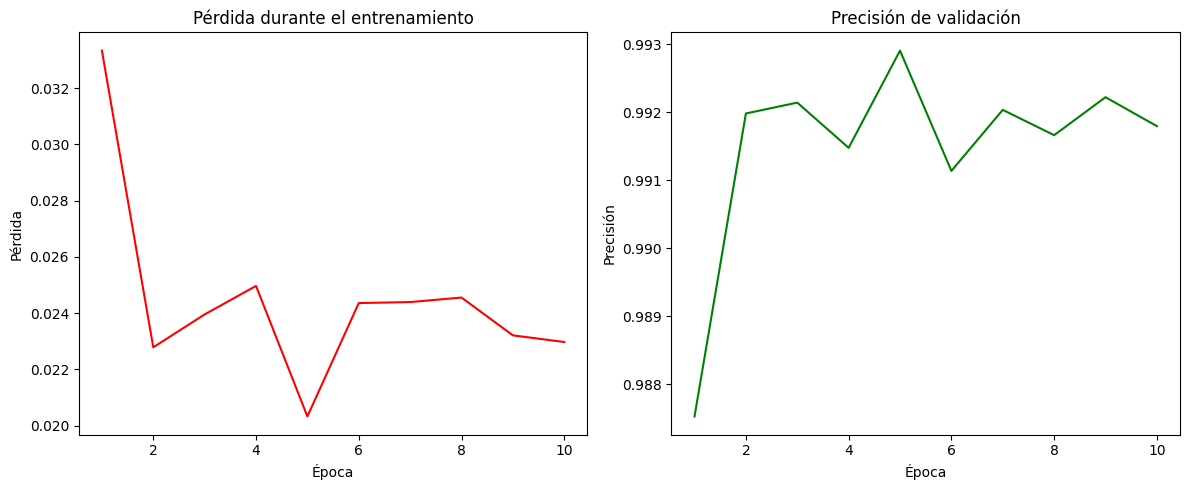

In [ ]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_losses, color='red')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de validación")

plt.tight_layout()
plt.show()

## Evaluación

Evaluación en el conjunto de test

In [ ]:
test_pred = predict(model, X_test_tensor) # Predicción
test_loss, test_acc = evaluate_model(test_pred, y_test_tensor) # Evaluación

print(f"\n🔍 Evaluación final en test:")
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_acc:.2f}")


🔍 Evaluación final en test:
Pérdida en test: 0.0234
Precisión en test: 0.99


Matriz de confusión de la predicción obtenida

In [ ]:
pred = torch.argmax(test_pred, dim=1).numpy()
pred_names = np.array([label_mapping[y] for y in pred])
y_test_names = np.array([label_mapping[y] for y in y_test])

# Calcular matriz de confusión
cm = confusion_matrix(y_test_names, pred_names)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names.unique(), yticklabels=y_test_names.unique())
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## Evaluación por clase

Evaluación por cada clase en el conjunto de test

In [ ]:
# Diccionario para almacenar los datos de test por clase
test_data_by_class = {}

# Asegúrate de que X_test_tensor y y_test_tensor estén alineados
for class_label in torch.unique(y_test_tensor):
    mask = y_test_tensor == class_label
    class_name = label_mapping[class_label.item()]
    test_data_by_class[class_name] = {
        'X': X_test_tensor[mask],
        'y': y_test_tensor[mask]
    }

In [ ]:
for cls, data in test_data_by_class.items():
    X_cls, y_cls = data['X'], data['y']
    cls_pred = predict(model, X_cls) # Predicción
    cls_loss, cls_acc = evaluate_model(cls_pred, y_cls) # Evaluación
    print(f"Clase: {cls}, Pérdida: {cls_loss:.4f}, Precisión: {cls_acc:.2f}")

Clase: Benign, Pérdida: 0.0162, Precisión: 0.99
Clase: FTP-BruteForce, Pérdida: 0.0048, Precisión: 1.00
Clase: SSH-Bruteforce, Pérdida: 0.0430, Precisión: 0.99
Clase: DoS attacks-GoldenEye, Pérdida: 0.0711, Precisión: 0.98
Clase: DoS attacks-Slowloris, Pérdida: 0.0634, Precisión: 0.99
Clase: DoS attacks-SlowHTTPTest, Pérdida: 0.0065, Precisión: 1.00
Clase: DoS attacks-Hulk, Pérdida: 0.0005, Precisión: 1.00
Clase: DDOS attack-LOIC-UDP, Pérdida: 0.0012, Precisión: 1.00
Clase: DDOS attack-HOIC, Pérdida: 0.0002, Precisión: 1.00
Clase: Brute Force -Web, Pérdida: 1.3901, Precisión: 0.80
Clase: Brute Force -XSS, Pérdida: 1.3981, Precisión: 0.86
Clase: SQL Injection, Pérdida: 7.3095, Precisión: 0.00
Clase: Infilteration, Pérdida: 0.4007, Precisión: 0.93
Clase: Bot, Pérdida: 0.0248, Precisión: 0.99


## Despliegue

In [ ]:
# --- Guardar el Diccionario de Estado del Modelo ---
model_save_path = 'netflow_lstm_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Diccionario de estado del modelo guardado en {model_save_path}")

In [ ]:
# Obtener las columnas de características (columnas originales antes de escalar, excluyendo etiquetas)
# Esto asume que 'sequences' está disponible y contiene la estructura antes de dividir en secuencias
if 'sequences' in locals() and len(sequences) > 0:
    # sequences[0] es un DataFrame de la primera secuencia procesada
    feature_columns = [col for col in sequences[0].columns if col not in ['Label', 'Label Code']]
else:
    # Fallback, asumiendo que df está disponible y tiene la estructura original.
    # Esto podría ser menos fiable si df fue modificado extensamente.
    print("Advertencia: 'sequences' no encontrado, intentando obtener feature_columns desde 'df'.")
    print("Asegúrate de que 'df' tenga la estructura correcta previa a la división en secuencias.")
    feature_columns = [col for col in df.columns if col not in ['Label', 'Label Code']]

In [ ]:
# --- Guardar el Escalador ---
scaler_save_path = 'scaler.joblib'
joblib.dump(scaler, scaler_save_path)

In [ ]:
# --- Guardar el Mapeo de Etiquetas ---
# json.dump convertirá las claves enteras a cadenas. Las convertiremos de nuevo a enteros al cargar.
label_mapping_save_path = 'label_mapping.json'
with open(label_mapping_save_path, 'w') as f:
    json.dump(label_mapping, f, indent=4)

In [ ]:
# --- Guardar Parámetros del Modelo (sequence_length, num_features, feature_columns) ---
actual_sequence_length = X_train_tensor.shape[1] # Esta es la sequence_length usada para padding/truncating
actual_num_features = X_train_tensor.shape[2]   # Esta es num_features

In [ ]:
model_params = {
    'sequence_length': actual_sequence_length,
    'num_features': actual_num_features,
    'hidden_dim': model.lstm.hidden_size, # Obtener hidden_dim de la instancia del modelo
    'output_dim': model.classifier.out_features, # Obtener output_dim de la instancia del modelo
    'feature_columns': feature_columns # Guardar el orden de las columnas de características
}
model_params_save_path = 'model_params.json'
with open(model_params_save_path, 'w') as f:
    json.dump(model_params, f, indent=4)

In [ ]:
print("\n--- Artefactos para producción: ---")
print(f"1. Diccionario de estado del modelo: {model_save_path}")
print(f"2. Escalador: {scaler_save_path}")
print(f"3. Mapeo de etiquetas: {label_mapping_save_path}")
print(f"4. Parámetros del modelo (incluyendo orden de características): {model_params_save_path}")
print(f"5. La definición de la clase NetFlowLSTM (necesaria para reconstruir el modelo).")